# Entrenamiento modelo LGBM

Esta notebook presenta el ajuste final de un modelo LightGBM para predecir las ventas del mes 2020-02.

El trabajo que se muestra es el resultado de un proceso iterativo de prueba y error, en el que se exploraron múltiples configuraciones de hiperparámetros, conjuntos de variables y estrategias de validación, sin que todas las variantes previas hayan logrado mejoras consistentes en las métricas de interés (RMSE y MAE, ni en el public de Kaggle).

Este punto de la experimentación representa la consolidación de las decisiones que aportaron valor al modelo final.

In [ ]:
import psutil
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
from src.utils.utils import get_base_dir
base_dir = get_base_dir()
base_dir

WindowsPath('C:/Users/lauta/Desktop/Lautaro/maestria_ds/labo3/repo-entrega')

### 1. Carga de datos

In [3]:
# Cargar datos a predecir
predict_file = base_dir / "data/predict/raw/product_id_apredecir201912.txt"
df_pred_orig = pd.read_csv(predict_file, sep="\t", encoding="utf-8")
print(f"Registros a predecir: {df_pred_orig.shape[0]}")
df_pred_orig.head()

Registros a predecir: 780


,product_id
0,20001
1,20002
2,20003
3,20004
4,20005


In [4]:
# leo directamente df_train, validation y predict
df_train = pd.read_feather(base_dir / "data/processed/df_train.feather")
df_validation = pd.read_feather(base_dir / "data/processed/df_validation.feather")
df_predict = pd.read_feather(base_dir / "data/processed/df_predict.feather")

# dimensiones particiones post-procesamiento
df_predict.shape, df_train.shape, df_validation.shape

((465660, 79), (12516572, 79), (4128320, 79))

In [5]:
new_cols = ['venta_t-2', 'venta_t-3', 'venta_t-6',
       'venta_t-9', 'venta_t-12', 'venta_t-24', 'media_3m', 'std_3m',
       'suma_3m', 'max_3m', 'min_3m', 'media_6m', 'std_6m', 'suma_6m',
       'max_6m', 'min_6m', 'media_9m', 'std_9m', 'suma_9m', 'max_9m', 'min_9m',
       'media_12m', 'std_12m', 'suma_12m', 'max_12m', 'min_12m', 'media_24m',
       'std_24m', 'suma_24m', 'max_24m', 'min_24m', 'pct_change_2_4m',
       'pct_change_4_7m', 'tendencia_2_4m', 'tendencia_4_6m', 'venta_año_ant',
       'mes_sin', 'mes_cos', 'trimestre_sin', 'trimestre_cos', 'es_enero',
       'es_diciembre', 'es_verano', 'es_invierno', 'producto_media_historica',
       'producto_volatilidad', 'cliente_media_historica', 'momentum_3m',
       'momentum_6m', 'aceleracion', 'categoria_media', 'vs_categoria',
       'marca_media', 'vs_marca', 'meses_sin_venta', 'frecuencia_compras_12m',
       'VarMensualGral', 'VarMensualAlim', 'IndiceMensualGral',
       'IndiceMensualAlim', 'dolar']
numerical_features = new_cols + ["mes", "año", "trimestre", "a_predecir"]
categorical_features = ["product_id", "customer_id", 'cat1', 'cat2', 'cat3', 'brand', 'descripcion']
model_features = numerical_features + categorical_features

In [6]:
# check memoria ram
mem = psutil.virtual_memory()
print(f"Memoria RAM disponible: {mem.available / (1024**3):.2f} GB")

Memoria RAM disponible: 4.90 GB


## Entrenamiento del modelo

In [7]:
import optuna

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }

    # probar con 3 semillas distintas
    seeds = [42, 96, 22]
    rmse_values = []

    for seed in seeds:

        model = lgb.LGBMRegressor(**params,
            objective='regression',
            metric='rmse',
            boosting_type='gbdt',
            random_state=seed,
            verbosity=-1)

        model.fit(
            df_train[model_features], df_train["target"],
            eval_set=[(df_validation[model_features], df_validation["target"])],
            eval_metric='rmse',
            categorical_feature=categorical_features,
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )

        preds = model.predict(df_validation[model_features])
        rmse = np.sqrt(mean_squared_error(df_validation["target"], preds))
        rmse_values.append(rmse)



    return np.mean(rmse_values)

In [8]:
# Configuración de Optuna
storage_url = "sqlite:///lgbm_study.db"

# Crear o cargar el estudio
study = optuna.create_study(
    direction='minimize',
    study_name="lgbm_regression_optuna",
    storage=storage_url,
    load_if_exists=True
)


# Encolar tu conjunto inicial de hiperparámetros
study.enqueue_trial({
    'learning_rate': 0.01687419508606365,
    'num_leaves': 123,
    'max_depth': 11,
    'colsample_bytree': 0.8290262199183336,
    'subsample': 0.721454421913562,
    'min_child_samples': 55,
    'reg_alpha': 0.6187094704138628,
    'reg_lambda': 0.795407032102261,
    'n_estimators': 551
})

print("Comenzando la optimización con Optuna...")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n Optimización completada...")
print("* Mejores hiperparámetros:")
print(study.best_params)
print(f"* Mejor RMSE: {study.best_value:.4f}")

print("\n Para ver el dashboard ejecutar en terminal:")
print("cd notebooks/4_modelado/lgbm")
print("optuna-dashboard sqlite:///lgbm_study.db")

[I 2025-08-10 11:51:26,392] Using an existing study with name 'lgbm_regression_optuna' instead of creating a new one.


Comenzando la optimización con Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-10 11:58:21,304] Trial 2 finished with value: 0.7496802890828063 and parameters: {'learning_rate': 0.01687419508606365, 'num_leaves': 123, 'max_depth': 11, 'colsample_bytree': 0.8290262199183336, 'subsample': 0.721454421913562, 'min_child_samples': 55, 'reg_alpha': 0.6187094704138628, 'reg_lambda': 0.795407032102261, 'n_estimators': 551}. Best is trial 2 with value: 0.7496802890828063.
[I 2025-08-10 12:02:17,631] Trial 3 finished with value: 0.7531592666378666 and parameters: {'learning_rate': 0.06377519356730126, 'num_leaves': 73, 'max_depth': 11, 'colsample_bytree': 0.994922461777236, 'subsample': 0.7910095344854962, 'min_child_samples': 50, 'reg_alpha': 0.13895006450650138, 'reg_lambda': 0.01404260940931279, 'n_estimators': 970}. Best is trial 2 with value: 0.7496802890828063.
[I 2025-08-10 12:08:55,471] Trial 4 finished with value: 0.7585433408124821 and parameters: {'learning_rate': 0.13338057862066038, 'num_leaves': 39, 'max_depth': 5, 'colsample_bytree': 0.61293731349

In [9]:
print("Mejores hiperparámetros:")
print(study.best_params)

Mejores hiperparámetros:
{'learning_rate': 0.033298202348152534, 'num_leaves': 121, 'max_depth': 12, 'colsample_bytree': 0.7702280076072465, 'subsample': 0.9451048961270575, 'min_child_samples': 63, 'reg_alpha': 0.8261485784018764, 'reg_lambda': 0.2801548449048477, 'n_estimators': 335}


In [10]:
print(f"Mejor RMSE en validación: {study.best_value:.4f}")

Mejor RMSE en validación: 0.7490


In [11]:
# Entrenar 15 modelos con diferentes semillas aleatorias
n_models = 15
models_list = []
mae_valid_list = []
rmse_valid_list = []
correlation_list = []

for i in range(n_models):
    best_model = lgb.LGBMRegressor(
        **study.best_params,
        objective='regression',
        metric='rmse',
        boosting_type='gbdt',
        random_state=42 + i,  # Diferente semilla para cada modelo
    )

    best_model.fit(
        df_train[model_features], df_train["target"],
        eval_set=[(df_validation[model_features], df_validation["target"])],
        eval_metric='rmse',
        categorical_feature=categorical_features,
        callbacks=[lgb.early_stopping(50)]
    )
    models_list.append(best_model)
    
    # Predicciones en validación
    y_pred_valid = best_model.predict(df_validation[model_features])

    # Métricas de evaluación
    mae_valid = mean_absolute_error(df_validation["target"], y_pred_valid)
    rmse_valid = np.sqrt(mean_squared_error(df_validation["target"], y_pred_valid))
    # Correlación entre predicciones y valores reales
    correlation = np.corrcoef(df_validation["target"], y_pred_valid)[0, 1]
    
    mae_valid_list.append(mae_valid)
    rmse_valid_list.append(rmse_valid)
    correlation_list.append(correlation)


print(f"Métricas en validación:")
print(f"MAE: {np.mean(mae_valid_list):.4f} ± {np.std(mae_valid_list):.4f}")
print(f"RMSE: {np.mean(rmse_valid_list):.4f} ± {np.std(rmse_valid_list):.4f}")
print(f"Correlación: {np.mean(correlation_list):.4f} ± {np.std(correlation_list):.4f}") 



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's rmse: 0.748459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[278]	valid_0's rmse: 0.749062
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[161]	valid_0's rmse: 0.753943
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's rmse: 0.752781
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[287]	valid_0's rmse: 0.748173
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's rmse: 0.750242
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[298]	valid_0's rmse: 0.751533
Training until validation scores don't improve for 50 rounds
Did not meet early stopp

### 7. Evaluación del modelo

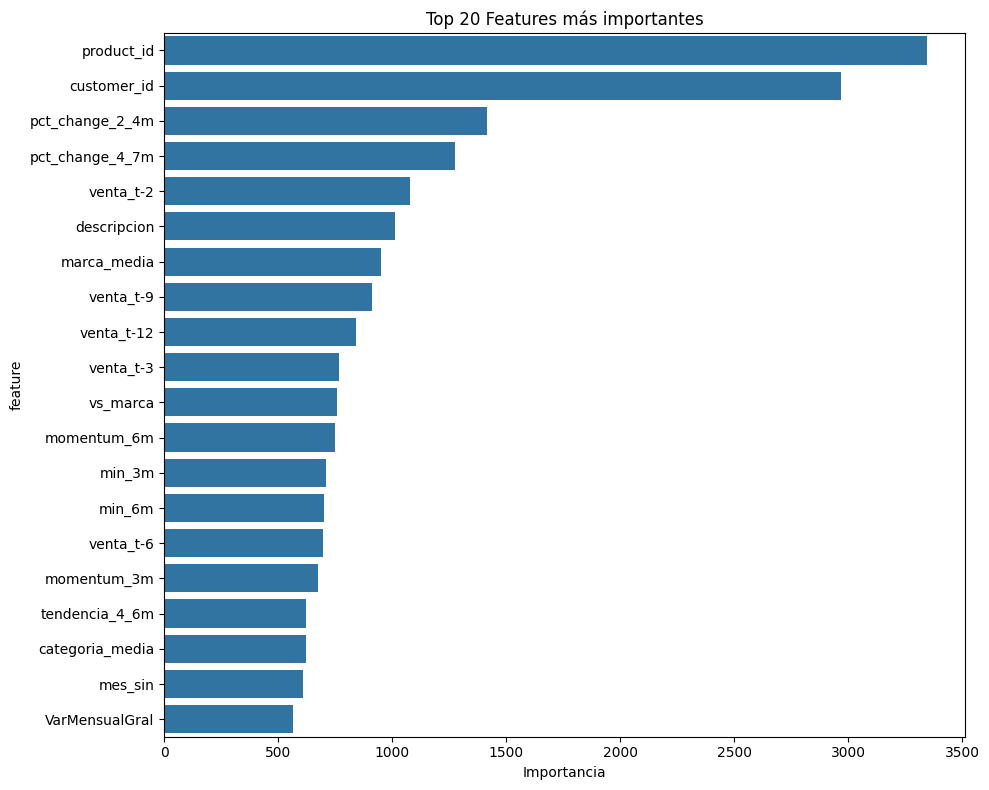

Top 20 features más importantes:


,feature,importance
45,product_id,3344.0
13,customer_id,2967.0
43,pct_change_2_4m,1413.0
44,pct_change_4_7m,1274.0
65,venta_t-2,1077.0
14,descripcion,1013.0
21,marca_media,948.0
69,venta_t-9,911.0
64,venta_t-12,842.0
67,venta_t-3,764.0


In [12]:
# Importancia de feature
modelo_para_fi = models_list[8]
feature_importance = pd.DataFrame()

for i in range(len(models_list)):
    feature_importance = pd.DataFrame({
        'feature': modelo_para_fi.feature_name_,
        'importance': modelo_para_fi.feature_importances_
    })#.sort_values('importance', ascending=False)
    feature_importance = pd.concat([feature_importance, feature_importance], axis=0)


feature_importance = feature_importance.groupby('feature').mean().reset_index().sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Features más importantes')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

print("Top 20 features más importantes:")
display(feature_importance.head(20))

### 8. Predicciones para febrero 2020

In [13]:
## predicciones para 202002
# Predicciones en el conjunto de predicción
preds_ensemble = np.zeros(df_predict.shape[0])
for model in models_list:
    preds_ensemble += model.predict(df_predict[model_features])
preds_ensemble /= n_models  # Promedio de predicciones
df_predict["predicted_target"] = preds_ensemble
df_predict["predicted_tn"] = df_predict["predicted_target"] + df_predict["venta_t-2"]

### 9. Guardar resultados

In [14]:
# Preparar resultados finales
if len(df_predict) > 0:
    results_final = df_predict[[
        'product_id', 'customer_id', 'periodo', 'predicted_tn'
    ]].copy()
    results_final.columns = ['product_id', 'customer_id', 'periodo', 'tn']
    
    
    # Comparar con predicciones objetivo
    if 'df_pred_orig' in locals():
        common_products = set(results_final['product_id']).intersection(set(df_pred_orig['product_id']))
        print(f"Productos en común con objetivo: {len(common_products)} de {len(df_pred_orig)}")
else:
    print("No se pudieron generar predicciones")

Productos en común con objetivo: 780 de 780


In [15]:
df_prediction_grouped_product_id = df_predict.groupby(['product_id'])["predicted_tn"].sum().reset_index()#.head(10)
df_prediction_grouped_product_id.columns = ["product_id","tn"]
df_prediction_grouped_product_id = df_pred_orig.merge(df_prediction_grouped_product_id, on='product_id', how='left')
df_prediction_grouped_product_id

,product_id,tn
0,20001,1108.548208
1,20002,1224.437310
2,20003,675.753929
3,20004,539.719046
4,20005,536.671452
...,...,...
775,21263,0.694170
776,21265,0.737044
777,21266,0.738548
778,21267,0.710705


In [16]:
time_tag = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
predict_file_processed = base_dir / f"data/predict/final/lgbm_optuna_y_ensamble_semillas_{time_tag}.csv"
df_prediction_grouped_product_id[["product_id","tn"]].to_csv(predict_file_processed, index=False)

In [17]:
df_prediction_grouped_product_id_orig = df_prediction_grouped_product_id.copy()

In [18]:
# uso modelo solo para el top de productos (segun validation)
df_prediction_grouped_product_id = df_prediction_grouped_product_id_orig.copy()
top_productos = df_validation.groupby('product_id')['tn'].sum().reset_index().sort_values(by='tn', ascending=False).reset_index(drop=True)
top_productos["tn_acum"] = top_productos["tn"].cumsum()
top_productos["tn_acum"] = top_productos["tn_acum"] / top_productos["tn_acum"].max() * 100
top_productos = top_productos[top_productos["tn_acum"] < 20]["product_id"].unique().tolist()

predict_medias = pd.read_csv(base_dir / f"data/predict/final/product_id_clase_3_ultimos_12_meses_20250613.csv")
df_prediction_grouped_product_id = df_prediction_grouped_product_id.merge(predict_medias, on='product_id', how='left', suffixes=('', '_magico'))
df_prediction_grouped_product_id["es_top"] = df_prediction_grouped_product_id["product_id"].isin(top_productos)

# para el top me quedo con el original, sino el magico
df_prediction_grouped_product_id["tn2"] = df_prediction_grouped_product_id["tn"].where(df_prediction_grouped_product_id["es_top"], df_prediction_grouped_product_id["tn_magico"])
df_prediction_grouped_product_id = df_prediction_grouped_product_id[["product_id","tn2"]]
df_prediction_grouped_product_id.columns = ["product_id","tn"]

time_tag = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
predict_file_processed = base_dir / f"data/predict/final/lgbm_optuna_y_ensamble_semillas_top20_prod_y_medias_{time_tag}.csv"
df_prediction_grouped_product_id[["product_id","tn"]].to_csv(predict_file_processed, index=False)


In [19]:
# uso modelo solo para el top de productos (segun validation)
df_prediction_grouped_product_id = df_prediction_grouped_product_id_orig.copy()
top_productos = df_validation.groupby('product_id')['tn'].sum().reset_index().sort_values(by='tn', ascending=False).reset_index(drop=True)
top_productos["tn_acum"] = top_productos["tn"].cumsum()
top_productos["tn_acum"] = top_productos["tn_acum"] / top_productos["tn_acum"].max() * 100
top_productos = top_productos[top_productos["tn_acum"] < 20]["product_id"].unique().tolist()

predict_magicos = pd.read_csv(base_dir / f"data/predict/final/product_id_clase_6_modelo_reg_simple_v1_magicos.csv")
df_prediction_grouped_product_id = df_prediction_grouped_product_id.merge(predict_magicos, on='product_id', how='left', suffixes=('', '_magico'))
df_prediction_grouped_product_id["es_top"] = df_prediction_grouped_product_id["product_id"].isin(top_productos)

# para el top me quedo con el original, sino el magico
df_prediction_grouped_product_id["tn2"] = df_prediction_grouped_product_id["tn"].where(df_prediction_grouped_product_id["es_top"], df_prediction_grouped_product_id["tn_magico"])
df_prediction_grouped_product_id = df_prediction_grouped_product_id[["product_id","tn2"]]
df_prediction_grouped_product_id.columns = ["product_id","tn"]

time_tag = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
predict_file_processed = base_dir / f"data/predict/final/lgbm_optuna_y_ensamble_semillas_top20_prod_y_magicos_{time_tag}.csv"
df_prediction_grouped_product_id[["product_id","tn"]].to_csv(predict_file_processed, index=False)


In [20]:
# uso modelo solo para el top de productos (segun validation)
df_prediction_grouped_product_id = df_prediction_grouped_product_id_orig.copy()
top_productos = df_validation.groupby('product_id')['tn'].sum().reset_index().sort_values(by='tn', ascending=False).reset_index(drop=True)
top_productos["tn_acum"] = top_productos["tn"].cumsum()
top_productos["tn_acum"] = top_productos["tn_acum"] / top_productos["tn_acum"].max() * 100
top_productos = top_productos[top_productos["tn_acum"] < 30]["product_id"].unique().tolist()

predict_medias = pd.read_csv(base_dir / f"data/predict/final/product_id_clase_3_ultimos_12_meses_20250613.csv")
df_prediction_grouped_product_id = df_prediction_grouped_product_id.merge(predict_medias, on='product_id', how='left', suffixes=('', '_magico'))
df_prediction_grouped_product_id["es_top"] = df_prediction_grouped_product_id["product_id"].isin(top_productos)

# para el top me quedo con el original, sino el magico
df_prediction_grouped_product_id["tn2"] = df_prediction_grouped_product_id["tn"].where(df_prediction_grouped_product_id["es_top"], df_prediction_grouped_product_id["tn_magico"])
df_prediction_grouped_product_id = df_prediction_grouped_product_id[["product_id","tn2"]]
df_prediction_grouped_product_id.columns = ["product_id","tn"]

time_tag = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
predict_file_processed = base_dir / f"data/predict/final/lgbm_optuna_y_ensamble_semillas_top30_prod_y_medias_{time_tag}.csv"
df_prediction_grouped_product_id[["product_id","tn"]].to_csv(predict_file_processed, index=False)


In [21]:
# uso modelo solo para el top de productos (segun validation)
df_prediction_grouped_product_id = df_prediction_grouped_product_id_orig.copy()
top_productos = df_validation.groupby('product_id')['tn'].sum().reset_index().sort_values(by='tn', ascending=False).reset_index(drop=True)
top_productos["tn_acum"] = top_productos["tn"].cumsum()
top_productos["tn_acum"] = top_productos["tn_acum"] / top_productos["tn_acum"].max() * 100
top_productos = top_productos[top_productos["tn_acum"] < 15]["product_id"].unique().tolist()

predict_medias = pd.read_csv(base_dir / f"data/predict/final/product_id_clase_3_ultimos_12_meses_20250613.csv")
df_prediction_grouped_product_id = df_prediction_grouped_product_id.merge(predict_medias, on='product_id', how='left', suffixes=('', '_magico'))
df_prediction_grouped_product_id["es_top"] = df_prediction_grouped_product_id["product_id"].isin(top_productos)

# para el top me quedo con el original, sino el magico
df_prediction_grouped_product_id["tn2"] = df_prediction_grouped_product_id["tn"].where(df_prediction_grouped_product_id["es_top"], df_prediction_grouped_product_id["tn_magico"])
df_prediction_grouped_product_id = df_prediction_grouped_product_id[["product_id","tn2"]]
df_prediction_grouped_product_id.columns = ["product_id","tn"]

time_tag = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
predict_file_processed = base_dir / f"data/predict/final/lgbm_optuna_y_ensamble_semillas_top15_prod_y_medias_{time_tag}.csv"
df_prediction_grouped_product_id[["product_id","tn"]].to_csv(predict_file_processed, index=False)


In [22]:
# para los "magicos" uso el modelo, sino con el archivo de magicos...
df_prediction_grouped_product_id = df_prediction_grouped_product_id_orig.copy()
magicos = [20001,20002,20003,20006,20008,20010,20011,20017,20018,20019,20021,20026,20028,20035,20039,20042,20044,20045,20046,20049,20051,20052,20053,20055,20086,20180,20193,20320,20532,20612,20637,20807,20838]

# importo el archivo

predict_magicos = pd.read_csv(base_dir / f"data/predict/final/product_id_clase_6_modelo_reg_simple_v1_magicos.csv")


df_prediction_grouped_product_id = df_prediction_grouped_product_id.merge(predict_magicos, on='product_id', how='left', suffixes=('', '_magico'))
df_prediction_grouped_product_id["es_magico"] = ~df_prediction_grouped_product_id["product_id"].isin(magicos)

df_prediction_grouped_product_id["tn2"] = df_prediction_grouped_product_id["tn_magico"].where(df_prediction_grouped_product_id["es_magico"], df_prediction_grouped_product_id["tn"])
df_prediction_grouped_product_id = df_prediction_grouped_product_id[["product_id","tn2"]]
df_prediction_grouped_product_id.columns = ["product_id","tn"]

time_tag = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
predict_file_processed = base_dir / f"data/predict/final/lgbm_optuna_y_ensamble_semillas_magicos_medias_{time_tag}.csv"
df_prediction_grouped_product_id[["product_id","tn"]].to_csv(predict_file_processed, index=False)